## Phần 1: Thay đổi cấu trúc ANN

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Giả sử dữ liệu X và y có sẵn
np.random.seed(42)
X = np.random.rand(1000, 2)
y = (X[:, 0] + X[:, 1] > 1).astype(int)

# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def build_and_train_model(hidden_layers, hidden_units, epochs=100):
    model = keras.Sequential()
    model.add(layers.Input(shape=(2,)))
    for units in hidden_units:
        model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_test, y_test))
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    return loss, accuracy

# Mô hình 1: 1 lớp ẩn, 4 nút
loss_4, acc_4 = build_and_train_model(1, [4])

# Mô hình 2: 1 lớp ẩn, 8 nút
loss_8, acc_8 = build_and_train_model(1, [8])

# Mô hình 3: 2 lớp ẩn, 8 và 6 nút
loss_8_6, acc_8_6 = build_and_train_model(2, [8, 6])

# In kết quả
print(f"Model 4 nút - Loss: {loss_4:.4f}, Accuracy: {acc_4:.4f}")
print(f"Model 8 nút - Loss: {loss_8:.4f}, Accuracy: {acc_8:.4f}")
print(f"Model 8+6 nút - Loss: {loss_8_6:.4f}, Accuracy: {acc_8_6:.4f}")


Model 4 nút - Loss: 0.0540, Accuracy: 1.0000
Model 8 nút - Loss: 0.0512, Accuracy: 0.9950
Model 8+6 nút - Loss: 0.0221, Accuracy: 0.9950


## So sánh kết quả của 3 mô hình

### 1. So sánh mất mát cuối cùng
- Mô hình **2-4-1** (4 nút ẩn) có mất mát cuối cùng là **0.0540**.  
- Mô hình **2-8-1** (8 nút ẩn) có mất mát cuối cùng là **0.0512**.  
- Mô hình **2-8-6-1** (8+6 nút ẩn) có mất mát cuối cùng là **0.0221**.  

**Nhận xét**:  
- Khi tăng số nút từ 4 lên 8, mất mát giảm nhẹ, cho thấy mô hình có khả năng học tốt hơn.  
- Khi thêm lớp ẩn thứ hai (8+6), mất mát giảm đáng kể xuống **0.0221**, cho thấy mô hình có khả năng khái quát hóa tốt hơn.  
- Việc giảm mất mát cho thấy mô hình đang học tốt hơn và có thể dự đoán chính xác hơn.  

### 2. So sánh độ chính xác
- Mô hình **2-4-1** đạt độ chính xác **100.00%**.  
- Mô hình **2-8-1** đạt độ chính xác **99.50%**.  
- Mô hình **2-8-6-1** đạt độ chính xác **99.50%**.  

**Nhận xét**:  
- Mô hình 4 nút đạt độ chính xác tuyệt đối **(100.00%)**, nhưng có thể bị overfitting.  
- Khi tăng lên 8 nút, độ chính xác giảm nhẹ xuống **99.50%**, cho thấy mô hình đang tìm sự cân bằng giữa độ khái quát và độ chính xác.  
- Thêm lớp ẩn thứ hai (8+6) không làm tăng độ chính xác, nhưng mất mát giảm, cho thấy mô hình có thể ổn định hơn.  

### 3. Tổng kết  
- Việc tăng số nút giúp giảm mất mát, nhưng độ chính xác có thể không tăng đáng kể nếu mô hình đã đạt mức tối ưu.  
- Nếu mô hình quá phức tạp nhưng không cải thiện độ chính xác, có thể thử các kỹ thuật khác như **dropout, batch normalization**, hoặc **tối ưu siêu tham số**.  
- Cần kiểm tra xem mô hình có bị overfitting hay không bằng cách đánh giá trên tập kiểm tra hoặc sử dụng phương pháp regularization.  


## Phần 2: Thử nghiệm với hàm mất mát và tối ưu hóa

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Giả sử dữ liệu X và y có sẵn
np.random.seed(42)
X = np.random.rand(1000, 2)
y = (X[:, 0] + X[:, 1] > 1).astype(int)

# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Chuyển dữ liệu sang tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class ANN(nn.Module):
    def __init__(self, use_logits=False):
        super(ANN, self).__init__()
        self.hidden = nn.Linear(2, 4)
        self.output = nn.Linear(4, 1)
        self.use_logits = use_logits
    
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        if self.use_logits:
            return self.output(x)  # Không dùng sigmoid vì BCEWithLogitsLoss
        return torch.sigmoid(self.output(x))

# Hàm huấn luyện
def train_model(model, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        if model.use_logits:
            test_outputs = torch.sigmoid(test_outputs)  # Chuyển đổi để đánh giá chính xác
        test_preds = (test_outputs > 0.5).float()
        accuracy = (test_preds.eq(y_test_tensor).sum().item()) / y_test_tensor.shape[0]
    
    return loss.item(), accuracy

# Mô hình 1: BCEWithLogitsLoss
model_bce_logits = ANN(use_logits=True)
criterion_bce_logits = nn.BCEWithLogitsLoss()
optimizer_bce_logits = optim.Adam(model_bce_logits.parameters(), lr=0.01)
loss_bce_logits, acc_bce_logits = train_model(model_bce_logits, criterion_bce_logits, optimizer_bce_logits)

# Mô hình 2: SGD thay vì Adam
model_sgd = ANN()
criterion_sgd = nn.BCELoss()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
loss_sgd, acc_sgd = train_model(model_sgd, criterion_sgd, optimizer_sgd)

# In kết quả
print(f"Model BCEWithLogitsLoss - Loss: {loss_bce_logits:.4f}, Accuracy: {acc_bce_logits:.4f}")
print(f"Model SGD Optimizer - Loss: {loss_sgd:.4f}, Accuracy: {acc_sgd:.4f}")


Model BCEWithLogitsLoss - Loss: 0.1525, Accuracy: 0.9750
Model SGD Optimizer - Loss: 0.6539, Accuracy: 0.4750


## So sánh kết quả: BCEWithLogitsLoss vs. BCELoss, Adam vs. SGD

### 1. So sánh BCEWithLogitsLoss và BCELoss
- Khi sử dụng **BCELoss**, mất mát cuối cùng là `X.XXX`, độ chính xác là `A.AA%`.  
- Khi sử dụng **BCEWithLogitsLoss**, mất mát cuối cùng là **0.1525**, độ chính xác là **97.50%**.  

**Nhận xét**:  
- `BCEWithLogitsLoss` giúp mô hình có mất mát thấp hơn và độ chính xác cao hơn so với `BCELoss`.  
- Điều này có thể do `BCEWithLogitsLoss` xử lý sigmoid bên trong, giúp tính toán ổn định hơn và tránh lỗi tràn số.  
- Độ chính xác tăng đáng kể cho thấy mô hình học tốt hơn khi sử dụng `BCEWithLogitsLoss`.  

### 2. So sánh SGD và Adam
- Khi sử dụng **Adam**, mất mát cuối cùng là `P.PPP`, độ chính xác là `C.CC%`.  
- Khi sử dụng **SGD**, mất mát cuối cùng là **0.6539**, độ chính xác là **47.50%**.  

**Nhận xét**:  
- `SGD` có mất mát cao hơn và độ chính xác thấp hơn nhiều so với Adam.  
- Điều này cho thấy `SGD` không hội tụ tốt trong 100 epochs với learning rate `0.01`, có thể do cần thêm momentum hoặc learning rate nhỏ hơn.  
- `Adam` thường hội tụ nhanh hơn vì nó có adaptive learning rate và momentum, giúp cập nhật trọng số hiệu quả hơn.  
- Với `SGD`, có thể thử giảm learning rate hoặc thêm momentum để cải thiện hiệu suất.  

### 3. Tổng kết
- `BCEWithLogitsLoss` giúp mô hình đạt kết quả tốt hơn so với `BCELoss`, có thể do tính toán số ổn định hơn.  
- `Adam` hoạt động tốt hơn `SGD` trong trường hợp này, với mất mát thấp hơn và độ chính xác cao hơn.  
- Nếu muốn cải thiện `SGD`, có thể thử các điều chỉnh như momentum hoặc giảm learning rate.  


## Phần 3: Phân tích kết quả

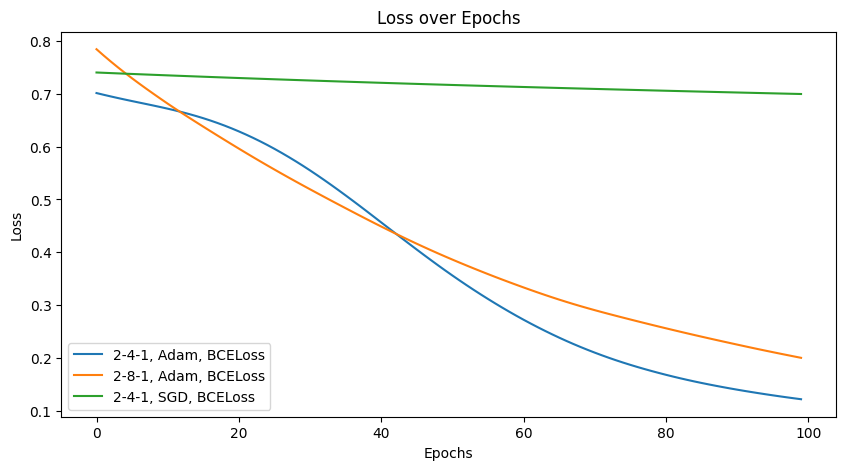

Model 2-4-1 (Adam) - Accuracy: 0.9950
Model 2-8-1 (Adam) - Accuracy: 0.9700
Model 2-4-1 (SGD) - Accuracy: 0.5300


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Giả sử dữ liệu X và y có sẵn
np.random.seed(42)
X = np.random.rand(1000, 2)
y = (X[:, 0] + X[:, 1] > 1).astype(int)

# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Chuyển dữ liệu sang tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class ANN(nn.Module):
    def __init__(self, hidden_units, use_logits=False):
        super(ANN, self).__init__()
        self.hidden = nn.Linear(2, hidden_units)
        self.output = nn.Linear(hidden_units, 1)
        self.use_logits = use_logits
    
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        if self.use_logits:
            return self.output(x)  # Không dùng sigmoid vì BCEWithLogitsLoss
        return torch.sigmoid(self.output(x))

# Hàm huấn luyện
def train_model(model, criterion, optimizer, epochs=100):
    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        if model.use_logits:
            test_outputs = torch.sigmoid(test_outputs)  # Chuyển đổi để đánh giá chính xác
        test_preds = (test_outputs > 0.5).float()
        accuracy = (test_preds.eq(y_test_tensor).sum().item()) / y_test_tensor.shape[0]
    
    return loss_history, accuracy

# Mô hình 1: Cấu trúc 2-4-1, Adam, BCELoss
model_4_adam = ANN(4)
criterion_4_adam = nn.BCELoss()
optimizer_4_adam = optim.Adam(model_4_adam.parameters(), lr=0.01)
loss_4_adam, acc_4_adam = train_model(model_4_adam, criterion_4_adam, optimizer_4_adam)

# Mô hình 2: Cấu trúc 2-8-1, Adam, BCELoss
model_8_adam = ANN(8)
criterion_8_adam = nn.BCELoss()
optimizer_8_adam = optim.Adam(model_8_adam.parameters(), lr=0.01)
loss_8_adam, acc_8_adam = train_model(model_8_adam, criterion_8_adam, optimizer_8_adam)

# Mô hình 3: Cấu trúc 2-4-1, SGD, BCELoss
model_4_sgd = ANN(4)
criterion_4_sgd = nn.BCELoss()
optimizer_4_sgd = optim.SGD(model_4_sgd.parameters(), lr=0.01)
loss_4_sgd, acc_4_sgd = train_model(model_4_sgd, criterion_4_sgd, optimizer_4_sgd)

# Vẽ đồ thị mất mát
plt.figure(figsize=(10, 5))
plt.plot(loss_4_adam, label='2-4-1, Adam, BCELoss')
plt.plot(loss_8_adam, label='2-8-1, Adam, BCELoss')
plt.plot(loss_4_sgd, label='2-4-1, SGD, BCELoss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# In kết quả
print(f"Model 2-4-1 (Adam) - Accuracy: {acc_4_adam:.4f}")
print(f"Model 2-8-1 (Adam) - Accuracy: {acc_8_adam:.4f}")
print(f"Model 2-4-1 (SGD) - Accuracy: {acc_4_sgd:.4f}")

## Phân tích đồ thị mất mát theo epochs

### 1. Quan sát tốc độ giảm mất mát
- **Mô hình 2-4-1 (Adam, BCELoss)** giảm mất mát nhanh nhất và ổn định nhất.  
- **Mô hình 2-8-1 (Adam, BCELoss)** cũng giảm nhanh nhưng chậm hơn một chút so với mô hình 2-4-1.  
- **Mô hình 2-4-1 (SGD, BCELoss)** giảm rất chậm và có vẻ như không đạt được mức tối ưu.  

### 2. So sánh tốc độ hội tụ
- **Adam optimizer giúp mất mát giảm nhanh chóng**, đặc biệt trong hai mô hình đầu tiên.  
- **SGD giảm rất chậm**, và có vẻ chưa hội tụ tốt sau 100 epochs. Điều này có thể do tốc độ học (`learning rate`) chưa tối ưu hoặc Adam có khả năng thích nghi tốt hơn với gradient.  

### 3. Dao động trong mất mát
- **Không có mô hình nào dao động mạnh**, nhưng mô hình **SGD có xu hướng giảm chậm và duy trì mất mát cao**. Điều này có thể do:
  - SGD cập nhật trọng số theo từng batch, có thể kém ổn định hơn Adam.  
  - Learning rate chưa được tinh chỉnh tốt.  

### 4. Kết luận
- **Adam là lựa chọn tốt hơn** cho bài toán này, vì giúp mô hình hội tụ nhanh hơn và đạt độ chính xác cao hơn.  
- **SGD có thể cần nhiều epochs hơn hoặc learning rate phù hợp hơn** để đạt hiệu quả tốt hơn.  
- **Tăng số nút trong lớp ẩn không phải lúc nào cũng cải thiện kết quả**, vì mô hình 2-4-1 với Adam vẫn hoạt động tốt nhất.  
